# Stable Diffusion XL + Inpaint + ControlNet + Refiner

In [4]:
import os 
from src.workflow import sdxl_inpaint_controlnet_refiner
from src.utils import cat_image_horizental

from diffusers.utils import load_image
import numpy as np
import cv2
from PIL import Image
import torch

os.environ["http_proxy"] = "127.0.0.1:15777"
os.environ["https_proxy"] = "127.0.0.1:15777"

In [2]:
image = load_image("/home/viper/Result/Week25/input.jpg")
mask = load_image("/home/viper/Result/Week25/mask.jpg")

c_image = np.array(mask)
c_image = cv2.Canny(c_image, 100, 200)
c_image = c_image[:, :, None]
c_image = np.concatenate([c_image, c_image, c_image], axis=2)
c_image = Image.fromarray(c_image)

prompt = "a picture of an earing stand on the marble, high resolution"
negative_prompt = "low quality, bad quality, blury"
controlnet_conditioning_scale = 1.0  # recommended for good generalization
steps = 50
guess_mode = False
guidance_scale = 7.5
strength = 1.0
control_guidance_start = 0.0
control_guidance_end = 1.0
guidance_rescale = 0.0
crops_coords_top_left = (0, 0)
aesthetic_score = 6.0 # 6.0
negative_aesthetic_score = 2.5
eta = 0.0
generator = torch.Generator(device="cuda").manual_seed(114514)

pipe = sdxl_inpaint_controlnet_refiner()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
res = pipe(image=image,
           mask=mask,
           c_image=c_image,
           prompt=prompt,
           negative_prompt=negative_prompt,
           generator=generator,
           controlnet_conditioning_scale=controlnet_conditioning_scale,
           guess_mode=guess_mode,
           guidance_scale=guidance_scale,
           strength=strength,
           control_guidance_start=control_guidance_start,
           control_guidance_end=control_guidance_end,
           guidance_rescale=guidance_rescale,
           crops_coords_top_left=crops_coords_top_left,
           aesthetic_score=aesthetic_score,
           negative_aesthetic_score=negative_aesthetic_score,
           eta=eta)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

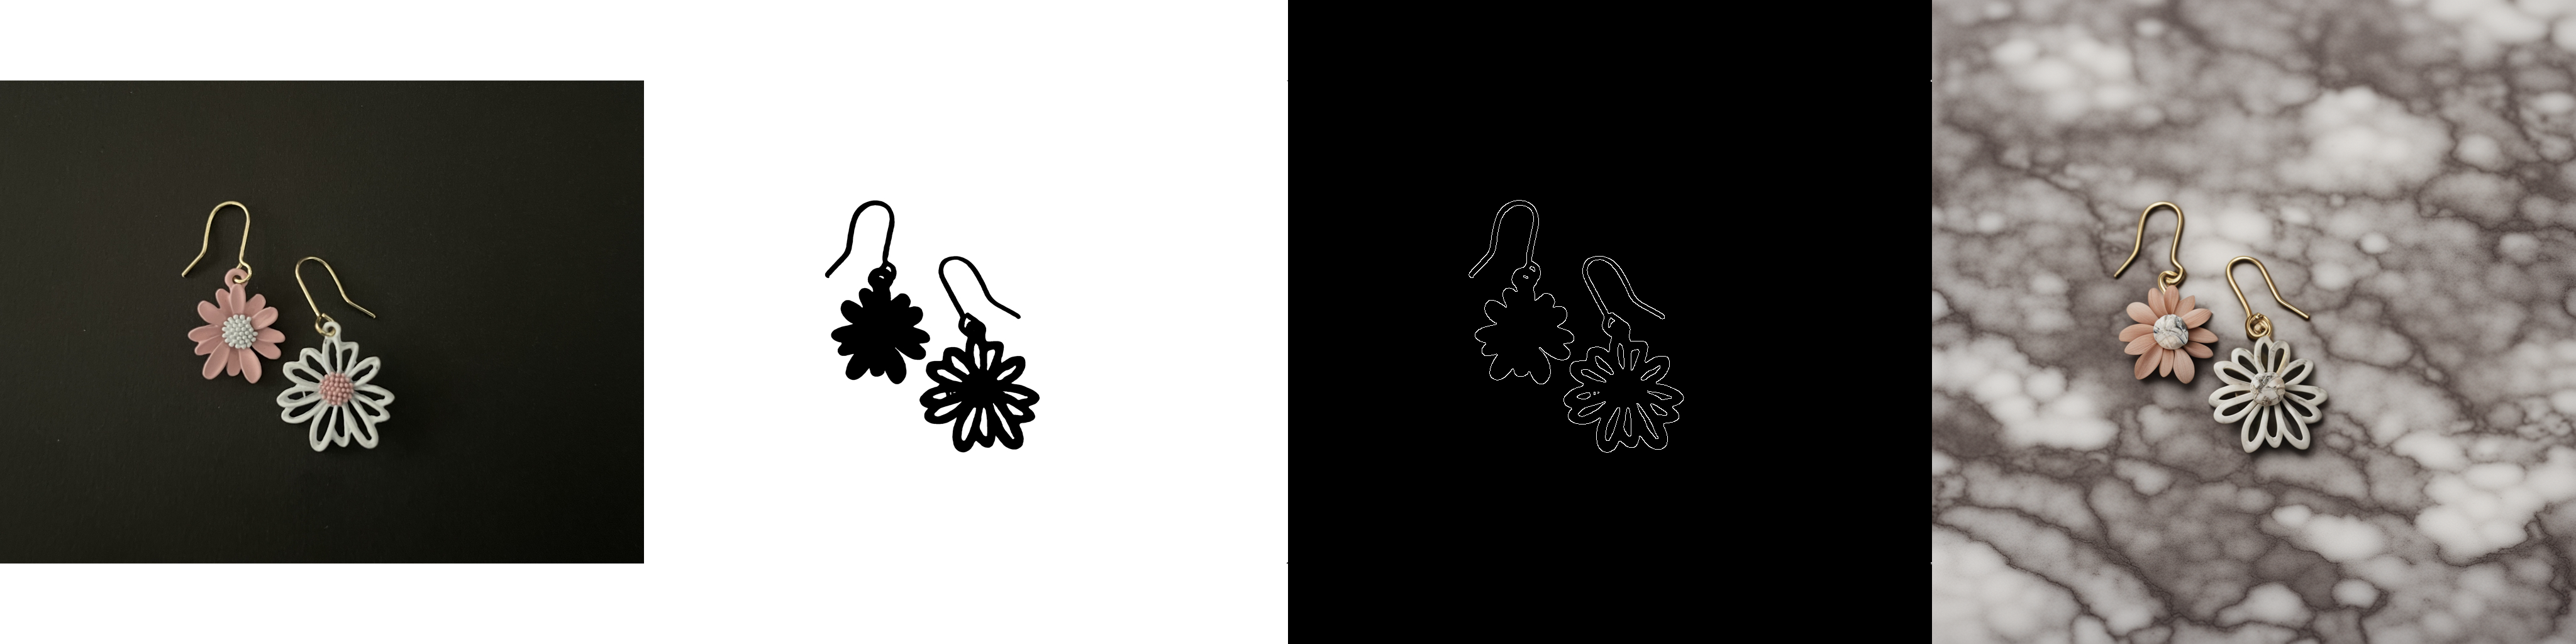

In [5]:
cat_image_horizental([image, mask, c_image, res])

# Stable Diffusion XL + Inpaint + ControlNet

In [ ]:
from diffusers import ControlNetModel, AutoencoderKL, EulerAncestralDiscreteScheduler
from src.pipeline import StableDiffusionXLInpaintControlNetPipeline
from diffusers.utils import load_image
from PIL import Image
import numpy as np
import torch
import cv2

In [2]:
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-sdxl-1.0",
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLInpaintControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
prompt = "aerial view, a futuristic research complex in a bright foggy jungle, hard lighting"
negative_prompt = 'low quality, bad quality, sketches'

image = load_image("/home/viper/Result/Week25/input.jpg")
mask = load_image("/home/viper/Result/Week25/mask.jpg")

controlnet_conditioning_scale = 0.5  # recommended for good generalization

c_image = np.array(mask)
c_image = cv2.Canny(c_image, 100, 200)
c_image = c_image[:, :, None]
c_image = np.concatenate([c_image, c_image, c_image], axis=2)
c_image = Image.fromarray(c_image)

generator = torch.Generator(device="cuda").manual_seed(1145141919)

pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
images = pipe(
                prompt, 
                negative_prompt=negative_prompt,
                image=image, 
                mask_image=mask, 
                control_image=c_image,
                num_inference_steps=50,
                generator=generator
    ).images

images[0].save(f"/home/viper/Result/Week26/ci-final.png")

  0%|          | 0/50 [00:00<?, ?it/s]